# GLM analysis on the main tasks
It uses nilearn and performs the following steps:
1. Load the data from fmriPrep in BIDS format
2. Iterate on the subjects to:
   1. Select the predictors and confounds for the design matrix
   2. Generate 1st level model
   3. Estimate contrast maps
3. Generate group level maps
4. Generate hMT+ mask

In [1]:
# Imports
import os
import glob
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.image import math_img
from nilearn.masking import apply_mask
#from src import mnitools # AAL labelling
# Import the AtlasBrowser class
from mni_to_atlas import AtlasBrowser
# Instantiate the AtlasBrowser class and specify the atlas to use
atlas = AtlasBrowser("AAL3")

In [2]:
# Settings
#data_dir = '/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK1/'
data_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK1/'
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep/fmriprep"
task_label = "01"
smoothing_fwhm = 4.0
high_pass_hz = 0.007
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")

# 2. Deal with contrast names
These should be balanced here.

In [3]:
# condition names
condition_names = ['Q1_p','Q2_p','Q3_p','Q4_p']

# create strings for contrasts in the format of "condition_name - Noise"
contrasts = []

# add contrast all conditions vs. noise
contrasts.append("Q1_p + Q2_p + Q3_p + Q4_p - Noise*4")

# iterate to add the other contrasts
for condition in condition_names:
    contrasts.append(condition + " - Noise")

# add more contrasts based on the arousal and valence
contrasts.append("Q1_p*0.5 + Q2_p*0.5 - Q3_p*0.5 - Q4_p*0.5") # positive arousal vs. negative arousal
contrasts.append("Q1_p*0.5 + Q4_p*0.5 - Q3_p*0.5 - Q2_p*0.5") # positive valence vs. negative valence

# just for fun - each Q against the other
contrasts.append("Q1_p - Q2_p")
contrasts.append("Q1_p - Q3_p")
contrasts.append("Q1_p - Q4_p")
contrasts.append("Q2_p - Q3_p")
contrasts.append("Q2_p - Q4_p")
contrasts.append("Q3_p - Q4_p")

contrasts

['Q1_p + Q2_p + Q3_p + Q4_p - Noise*4',
 'Q1_p - Noise',
 'Q2_p - Noise',
 'Q3_p - Noise',
 'Q4_p - Noise',
 'Q1_p*0.5 + Q2_p*0.5 - Q3_p*0.5 - Q4_p*0.5',
 'Q1_p*0.5 + Q4_p*0.5 - Q3_p*0.5 - Q2_p*0.5',
 'Q1_p - Q2_p',
 'Q1_p - Q3_p',
 'Q1_p - Q4_p',
 'Q2_p - Q3_p',
 'Q2_p - Q4_p',
 'Q3_p - Q4_p']

In [4]:
# This is to use the contrasts as names for the output files
contrasts_renamed = ['Q1234MinusNoise',
                     'Q1MinusNoise',
                     'Q2MinusNoise',
                     'Q3MinusNoise',
                     'Q4MinusNoise',
                     'PositiveArousalMinusNegativeArousal',
                     'PositiveValenceMinusNegativeValence',
                     'Q1MinusQ2',
                     'Q1MinusQ3',
                     'Q1MinusQ4',
                     'Q2MinusQ3',
                     'Q2MinusQ4',
                     'Q3MinusQ4']

contrasts_renamed

['Q1234MinusNoise',
 'Q1MinusNoise',
 'Q2MinusNoise',
 'Q3MinusNoise',
 'Q4MinusNoise',
 'PositiveArousalMinusNegativeArousal',
 'PositiveValenceMinusNegativeValence',
 'Q1MinusQ2',
 'Q1MinusQ3',
 'Q1MinusQ4',
 'Q2MinusQ3',
 'Q2MinusQ4',
 'Q3MinusQ4']

# 4. Group level analysis

In [33]:
# just some paths again
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")
out_dir_group = os.path.join(data_dir,"derivatives","nilearn_glm","group")
if not os.path.exists(out_dir_group):
    os.makedirs(out_dir_group)

In [34]:
# choose a contrast
c_idx = 0

# List all tmap nii.gz files
tmap_files = glob.glob(
    os.path.join(out_dir,
        f"sub-*_task-{task_label}_stat-t_con-{contrasts_renamed[c_idx]}.nii.gz"
    )
)
tmap_files.sort()

# List all zmap nii.gz files
zmap_files = glob.glob(
    os.path.join(out_dir,
        f"sub-*_task-{task_label}_stat-z_con-{contrasts_renamed[c_idx]}.nii.gz"
    )
)
zmap_files.sort()

subject_list = [os.path.basename(f).split('_')[0] for f in tmap_files]
subject_list

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-10',
 'sub-11',
 'sub-12',
 'sub-13',
 'sub-14',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18',
 'sub-19']

In [7]:
# remove subjects 5, 6, and 18 from tmap_files and zmap_files and subject_list
# because they have no data for a given quadrant
# tmap_files = [f for f in tmap_files if not 'sub-05' in f]
# tmap_files = [f for f in tmap_files if not 'sub-06' in f]
# tmap_files = [f for f in tmap_files if not 'sub-18' in f]
# zmap_files = [f for f in zmap_files if not 'sub-05' in f]
# zmap_files = [f for f in zmap_files if not 'sub-06' in f]
# zmap_files = [f for f in zmap_files if not 'sub-18' in f]
# subject_list = [f for f in subject_list if not 'sub-05' in f]
# subject_list = [f for f in subject_list if not 'sub-06' in f]
# subject_list = [f for f in subject_list if not 'sub-18' in f]
# print(subject_list)
# print(len(subject_list))

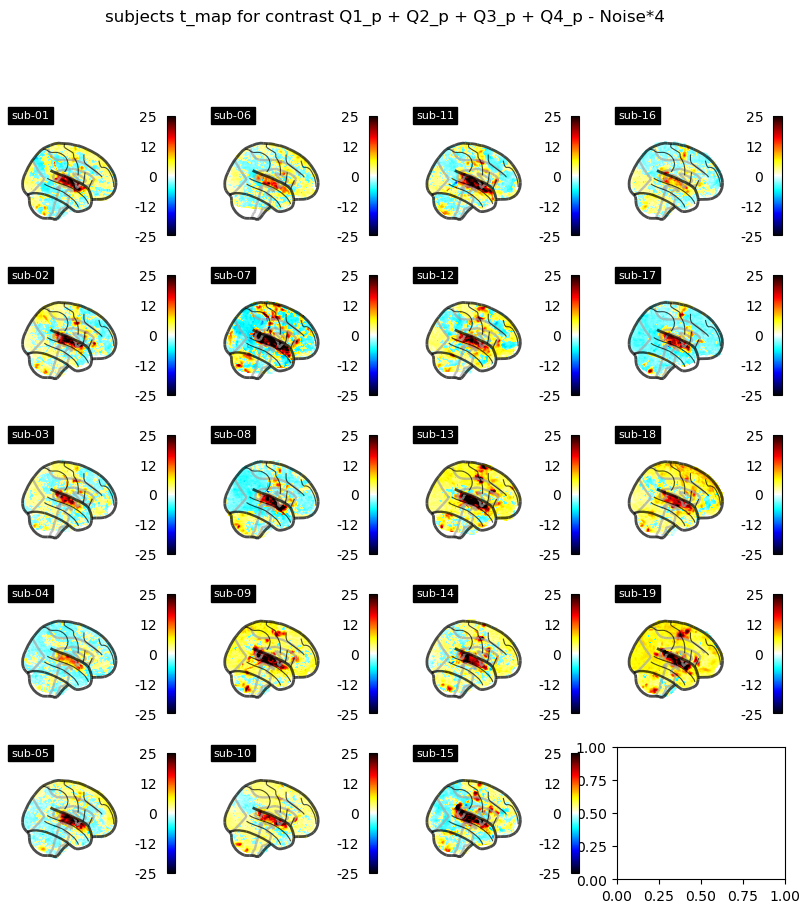

In [8]:
#| label: plot_glass_matrix_singlesubject

# Plot all subjects t_maps for a given contrast
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10))

for cidx, tmap in enumerate(tmap_files):
    P = plotting.plot_glass_brain(
        tmap,
        colorbar=True,
        threshold=0,
        vmax=25,
        axes=axes[cidx % 5, int(cidx / 5)],
        plot_abs=False,
        display_mode="x",
    )
    P.title(subject_list[cidx], size=8)

fig.suptitle(f"subjects t_map for contrast {contrasts[c_idx]}")
plt.show()

In [40]:
# create design matrix for 2nd level
second_level_input = zmap_files
design_matrix_g = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],
)

# define 2nd level model
second_level_model = SecondLevelModel(smoothing_fwhm=6.0, n_jobs=12)
second_level_model.minimize_memory = False
second_level_model = second_level_model.fit(
    second_level_input,
    design_matrix=design_matrix_g,
)

# compute contrast (z score map)
z_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="z_score",
)

# compute contrast (t score map)
t_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type="stat",
)

# compute contrast (beta map)
beta_map_g = second_level_model.compute_contrast(
    second_level_contrast="intercept",
    output_type='effect_size',
)

In [49]:
# Threshold zmap and plot it
hc = 'fdr' # None, 'bonferroni', 'fdr'
ct = 0 # cluster threshold
alpha = 0.005 # p-value threshold

clean_map_g, threshold_g = threshold_stats_img(
    z_map_g, alpha=alpha, height_control=hc, cluster_threshold=ct
)

In [29]:
threshold_g

3.7067231380344787

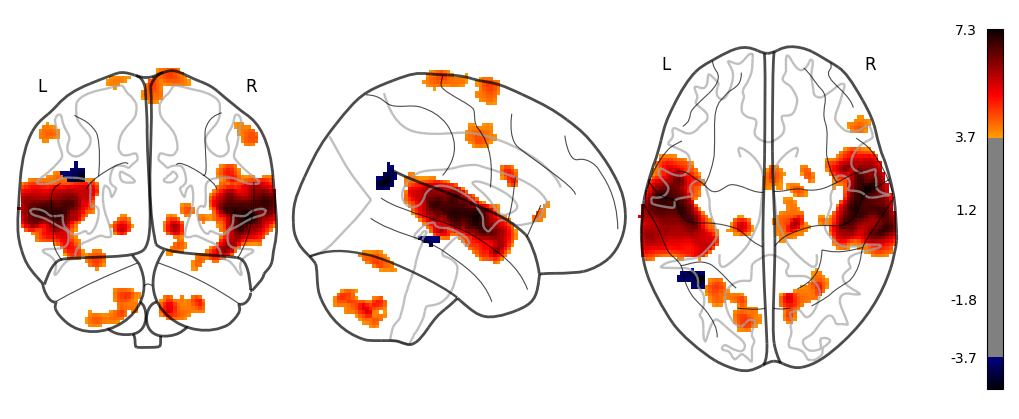

In [45]:
# glass brain
plotting.plot_glass_brain(
    clean_map_g,
    colorbar=True,
    threshold=threshold_g,
    plot_abs=False,
    display_mode="ortho",
    #vmax=8,
    figure=plt.figure(figsize=(10, 4)),
    symmetric_cbar=False,
    #cmap=nilearn_cmaps["cold_hot"],
)

plt.savefig(os.path.join(out_dir_group,
                         f"group_task-{task_label}_plot-z_con-_{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.png"))

In [50]:
# Export cluster table
table_g,cluster_map_g = get_clusters_table(z_map_g, threshold_g, ct,
                                return_label_maps=True)

# Save cluster_map_g
cluster_map_g[0].to_filename(os.path.join(out_dir_group,
                          f"group_task-{task_label}_clustermap_con-{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.nii.gz"))

# # AAL labelling
# table_g['AAL'] = 'NA'

# # Iterate over rows in table
# for index, row in table_g.iterrows():
#     # add AAL structure to dataframe
#     _, tab_ = mnitools.find_structure([row['X'], row['Y'], row['Z']])
#     aal_s = tab_[-1][-1]
#     table_g.loc[index, 'AAL'] = aal_s

# AAL3 labelling
# Provide MNI coordinates as an (n x 3) array
coordinates = table_g[['X','Y','Z']].to_numpy()

# Find the brain regions at the MNI coordinates (plotting is optional)
aal_labels = atlas.find_regions(coordinates, plot=False)

# Add the labels to the table
table_g['AAL3'] = aal_labels

table_g.to_csv(os.path.join(out_dir_group,
                          f"group_task-{task_label}_table-clusters_con-{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.tsv"),sep='\t')

table_g.to_csv(f"group_task-{task_label}_table-clusters_con-{contrasts_renamed[c_idx]}_c-{hc}_p-{alpha}_clusterk-{ct}.tsv",sep='\t')

table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,57.5,-4.5,1.5,7.291228,34968,Temporal_Sup_R
1,1a,49.5,-14.5,3.5,7.051939,,Heschl_R
2,1b,65.5,-28.5,7.5,6.893036,,Temporal_Sup_R
3,1c,43.5,-24.5,5.5,6.823291,,Temporal_Sup_R
4,2,-58.5,-10.5,3.5,7.005290,34376,Temporal_Sup_L
5,2a,-48.5,-16.5,1.5,6.954840,,Temporal_Sup_L
6,2b,-44.5,-22.5,7.5,6.749131,,Temporal_Sup_L
7,2c,-50.5,-0.5,-2.5,6.428437,,Temporal_Sup_L
8,3,15.5,-24.5,-4.5,5.838663,952,Thal_MGN_R
9,4,-14.5,-26.5,-6.5,5.501539,816,Undefined


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views


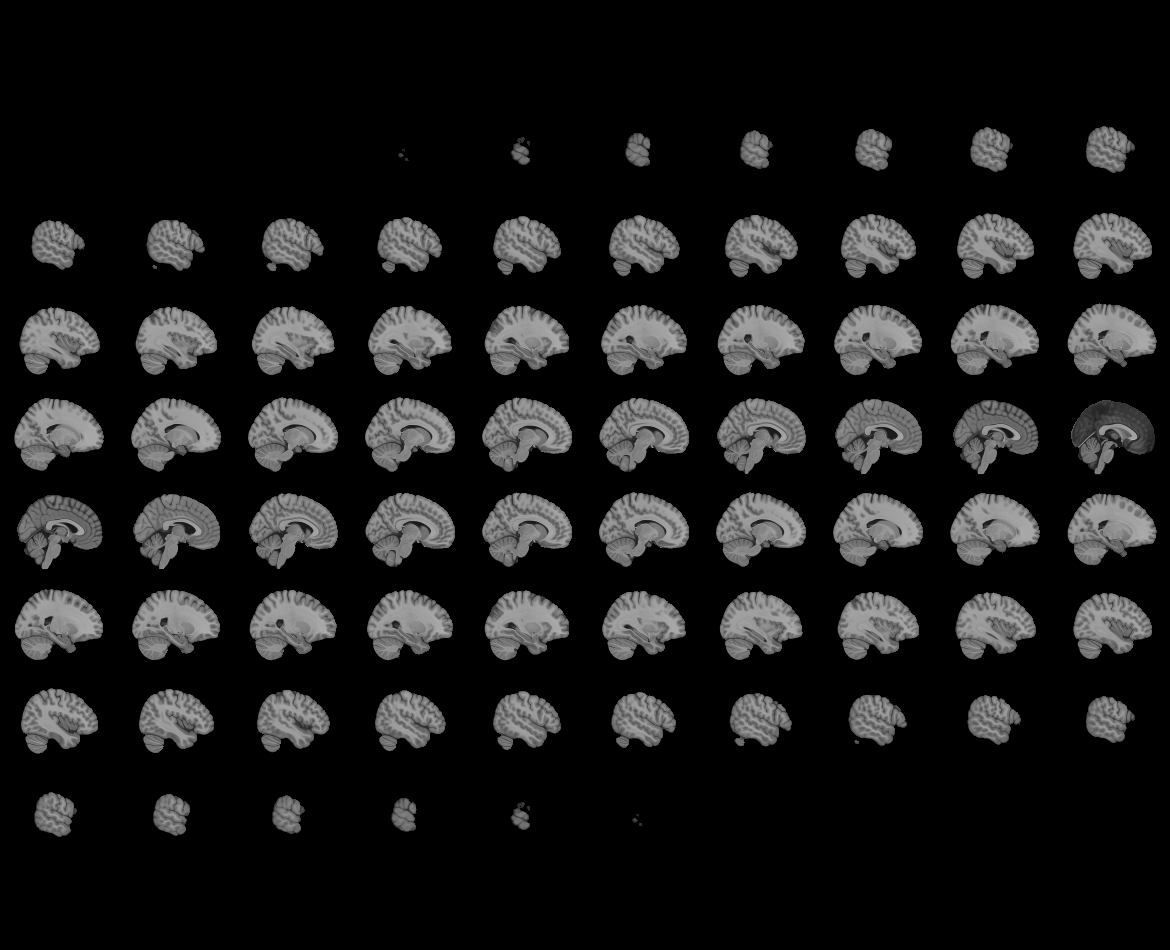
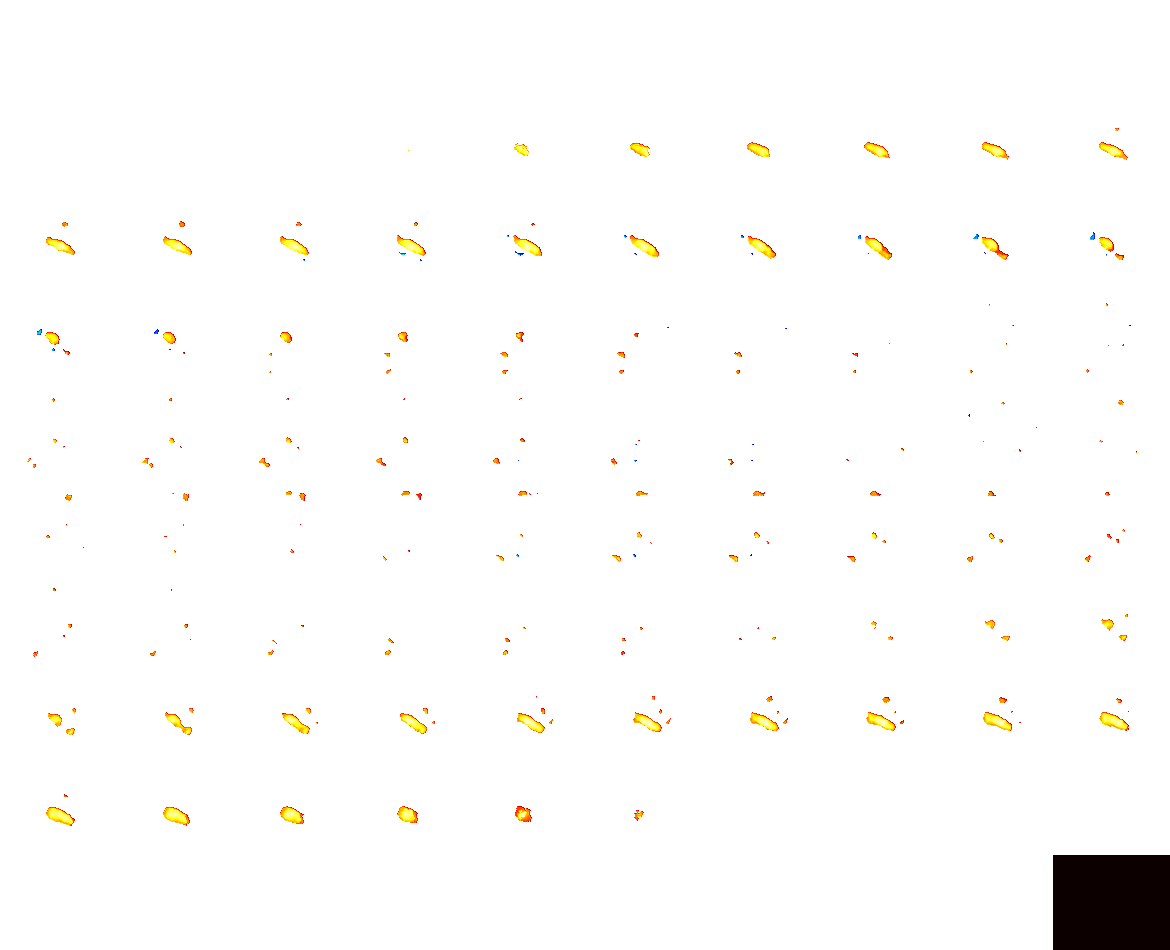

In [51]:
# View map interactively
plotting.view_img(clean_map_g,
         threshold=threshold_g,
         width_view=1000,
        )

In [61]:
from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    second_level_input,
    design_matrix=design_matrix_g,
    model_intercept=True,
    n_perm=5000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=False,
    smoothing_fwhm=6.0,
    n_jobs=6,
    threshold=0.005,
    tfce=True,
)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/masking.py:976: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views


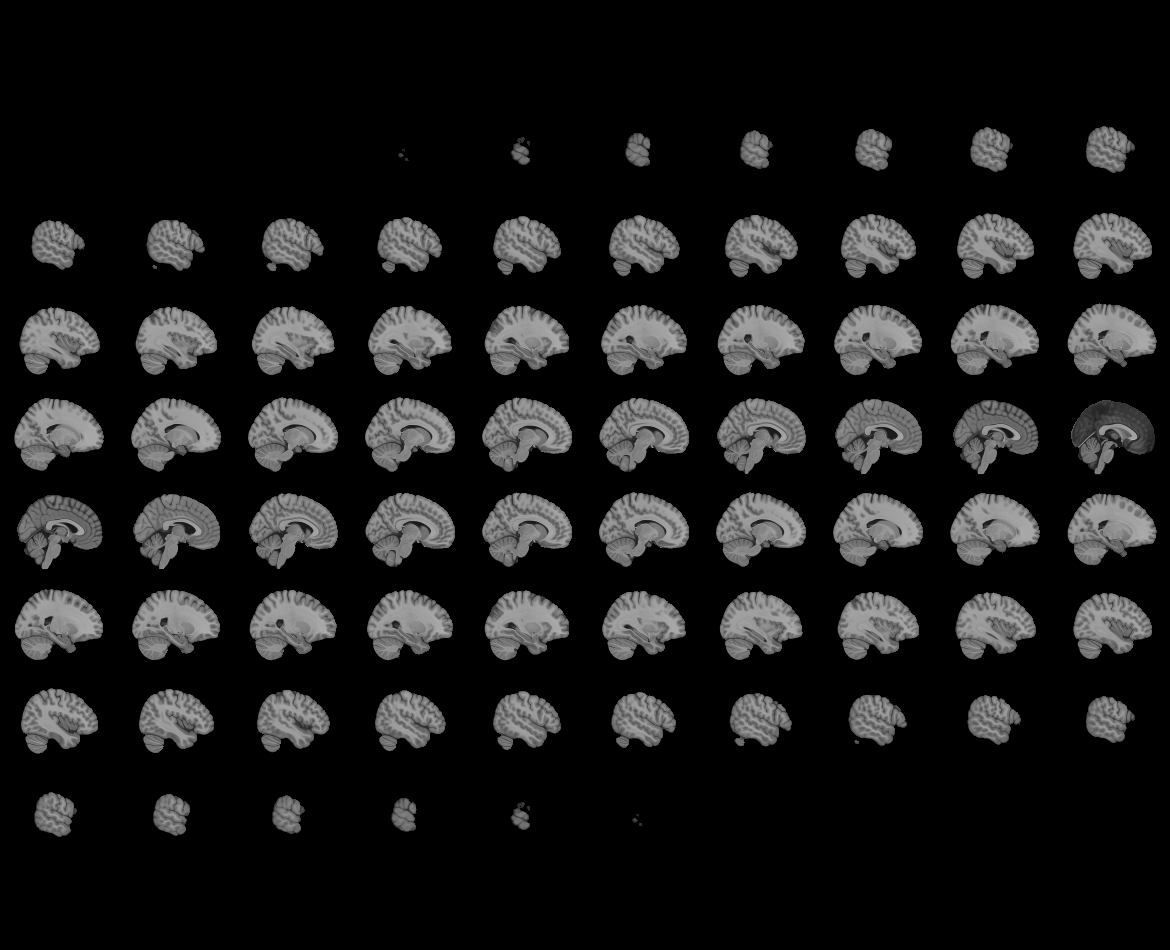
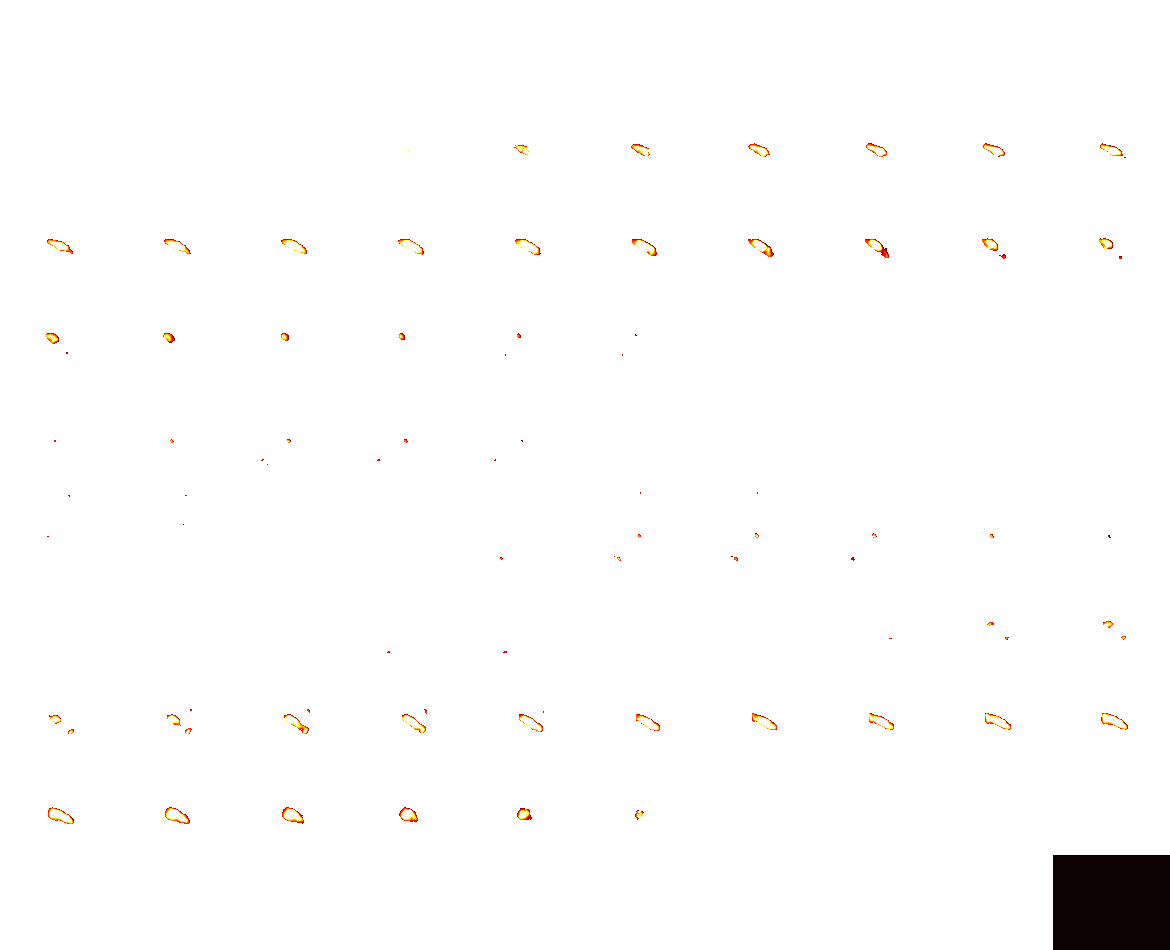

In [62]:
plotting.view_img(out_dict["logp_max_t"], colorbar=True, threshold=1, width_view=1000)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views


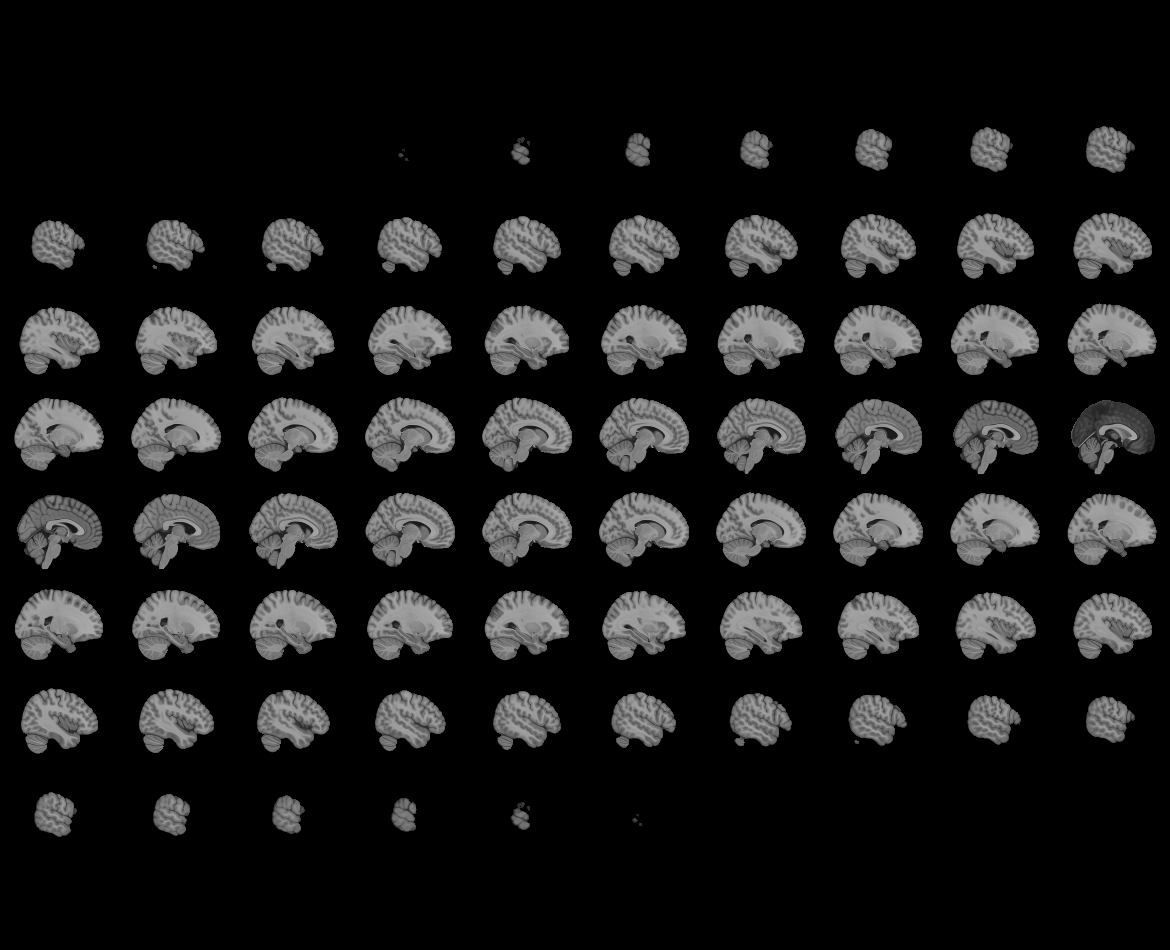
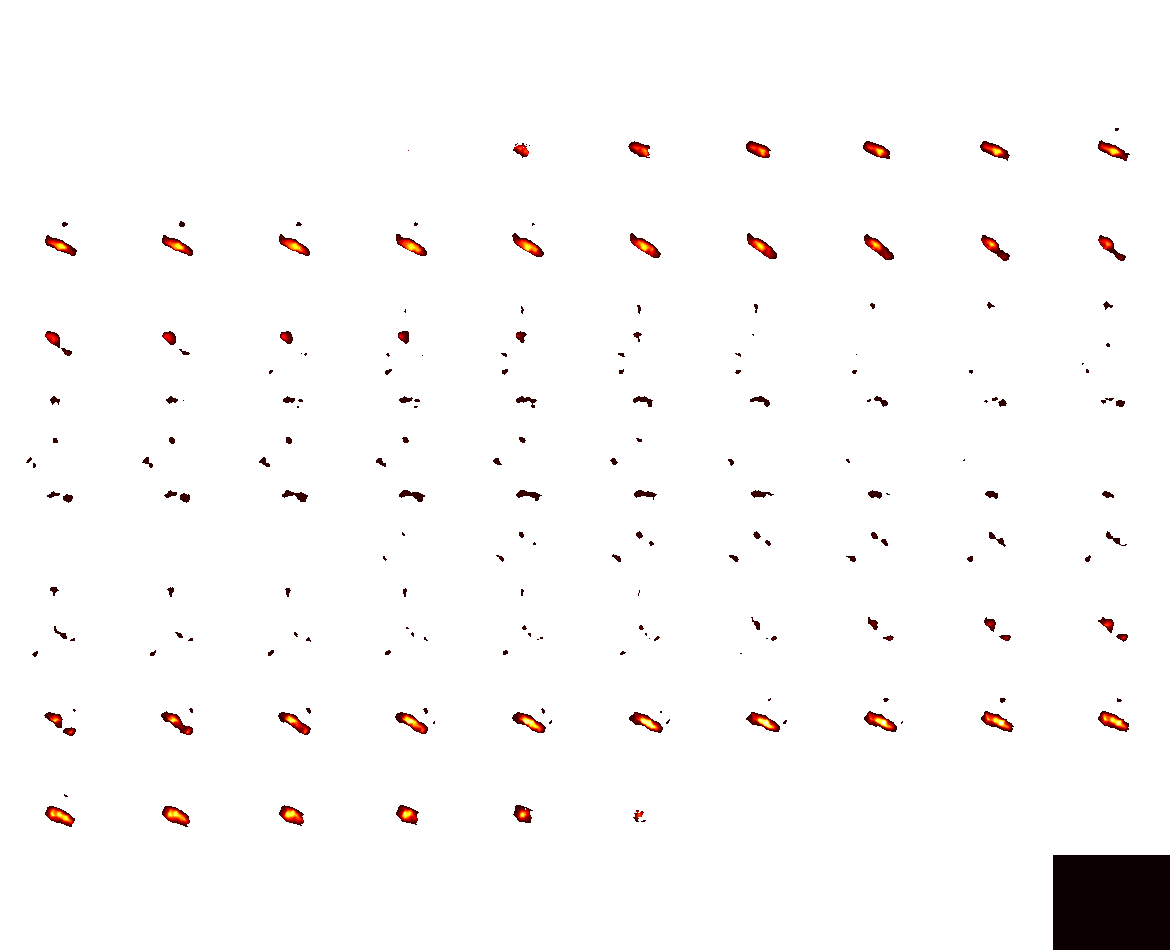

In [63]:
plotting.view_img(out_dict["tfce"], colorbar=True, threshold=10000, width_view=1000)

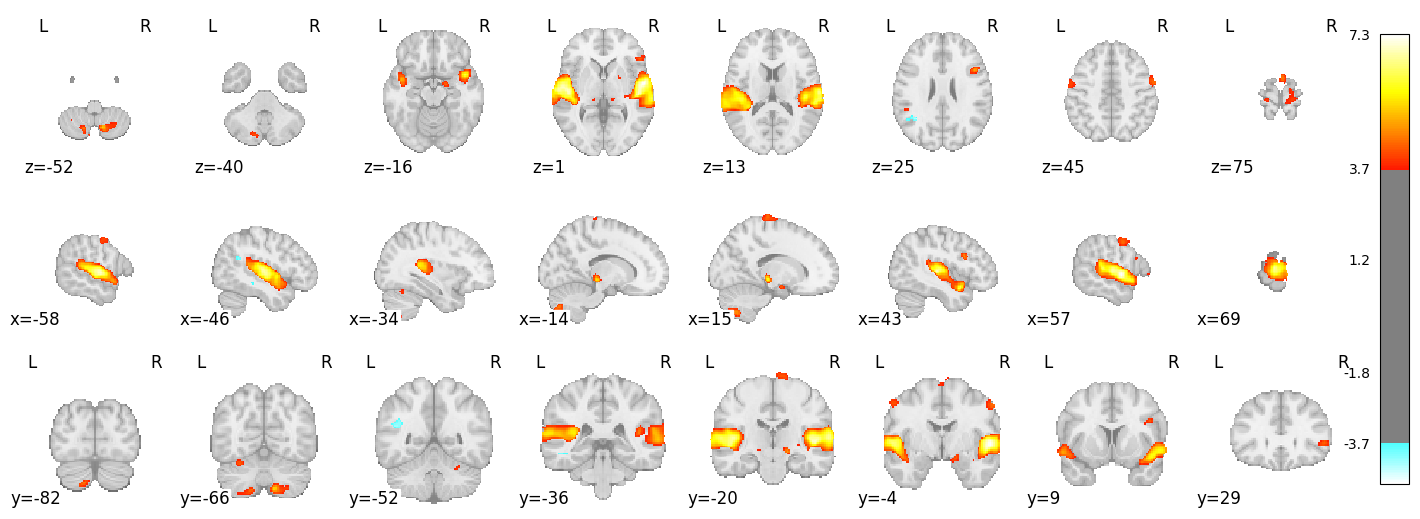

In [47]:
# create slice view of clean_map_g
plotting.plot_stat_map(
    clean_map_g,
    threshold=threshold_g,
    display_mode="mosaic",
    cut_coords=8,
    colorbar=True,
    figure=plt.figure(figsize=(14, 5)),
    symmetric_cbar=False,
)

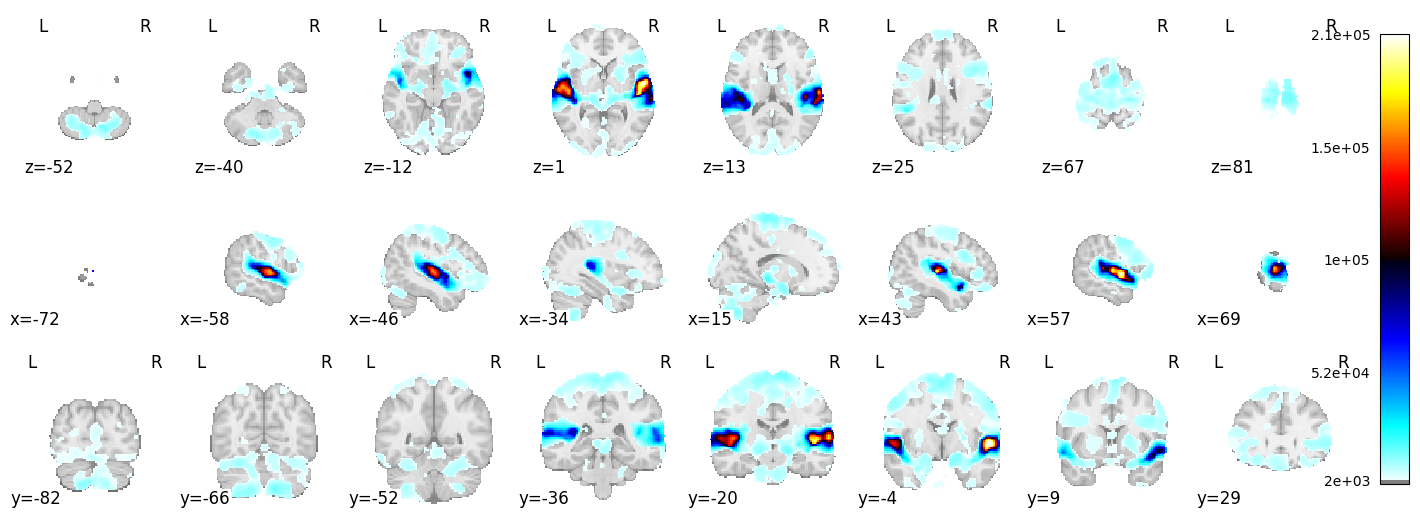

In [60]:
# create slice view of clean_map_g
plotting.plot_stat_map(
    out_dict["tfce"],
    threshold=2000,
    display_mode="mosaic",
    cut_coords=8,
    colorbar=True,
    figure=plt.figure(figsize=(14, 5)),
    symmetric_cbar=False,
)